## Analisis de Resultados

En cada carpeta estan consolidados los logs de resultados de cada uno de los contenedores que prestan el servicio.

En la carpeta *resultado* estan los archivos de logs del análisis del voting y la detección de errores

In [23]:
import pandas as pd
import re
import os
from typing import List, Dict, Optional, Any
import matplotlib.pyplot as plt # Importar matplotlib


### Definicion de funciones de carga de datos

In [2]:
def parse_log_line(line: str) -> Optional[Dict[str, Any]]:
    """
    Analiza una sola línea de log usando una expresión regular.

    Args:
        line: La línea de texto del archivo de log.

    Returns:
        Un diccionario con los datos extraídos si la línea coincide con el patrón,
        o None si no coincide.
    """
    # Expresión regular para extraer los datos de cada línea
    # Captura: Timestamp, valor de match, id_pedido, response 1, response 2, response 3
    # Es flexible con los espacios alrededor de las comas y los dos puntos.
    pattern = re.compile(
        r'\[(.*?)\]\s+'          # 1: Timestamp (cualquier caracter entre corchetes)
        r'match:\s*(true|false),' # 2: Valor de match ('true' o 'false')
        r'\s*id_pedido:\s*(\d+),' # 3: ID Pedido (dígitos)
        r'\s*response 1:\s*(\d+)\s*,' # 4: Response 1 (dígitos)
        r'\s*response 2:\s*(\d+)\s*,' # 5: Response 2 (dígitos)
        r'\s*response 3:\s*(\d+)'    # 6: Response 3 (dígitos)
    )
    match = pattern.search(line)

    if match:
        # Extraer los grupos capturados por la regex
        timestamp_str, match_str, id_pedido_str, resp1_str, resp2_str, resp3_str = match.groups()

        # Convertir los datos a los tipos apropiados
        try:
            data = {
                'timestamp': pd.to_datetime(timestamp_str), # Convertir a objeto datetime
                'match': match_str.lower() == 'true',      # Convertir a booleano
                'id_pedido': int(id_pedido_str),           # Convertir a entero
                'response_1': int(resp1_str),              # Convertir a entero
                'response_2': int(resp2_str),              # Convertir a entero
                'response_3': int(resp3_str)               # Convertir a entero
            }
            return data
        except ValueError as e:
            print(f"Error al convertir datos en la línea: {line.strip()}. Error: {e}")
            return None
    else:
        # Informar si una línea no coincide con el formato esperado
        # print(f"Línea ignorada (no coincide con el formato): {line.strip()}")
        return None


In [7]:
def load_logs_to_dataframe(file_paths: List[str]) -> pd.DataFrame:
    """
    Carga datos de múltiples archivos de log en un DataFrame de Pandas.

    Args:
        file_paths: Una lista de rutas a los archivos de log.

    Returns:
        Un DataFrame de Pandas que contiene los datos combinados de todos los archivos.
    """
    all_data = [] # Lista para almacenar los datos de todas las líneas válidas

    for file_path in file_paths:
        print(f"Procesando archivo: {file_path}...")
        file_name = os.path.basename(file_path)
        # Extraer el ID de ejecución del nombre del archivo usando regex
        execution_id = None
        id_match = re.search(r'coordinador(\d+)\.txt', file_name)
        if id_match:
            try:
                execution_id = int(id_match.group(1))
            except ValueError:
                print(f"Advertencia: No se pudo convertir el ID de ejecución a entero en {file_name}")

        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                for line_num, line in enumerate(f, 1): # Enumerar líneas para mejor reporte de errores
                    parsed_data = parse_log_line(line)
                    if parsed_data:
                        # Añadir el ID de ejecución y el nombre del archivo
                        parsed_data['execution_id'] = execution_id
                        parsed_data['source_file'] = file_name
                        all_data.append(parsed_data)
                    # else:
                        # Opcional: Informar sobre la línea específica que falló
                        # print(f"Línea {line_num} en {file_name} ignorada (formato inválido).")

        except FileNotFoundError:
            print(f"Error: Archivo no encontrado - {file_path}")
        except Exception as e:
            print(f"Error inesperado al procesar el archivo {file_path}: {e}")

    print(f"Se procesaron {len(all_data)} líneas válidas en total.")

    if not all_data:
        print("No se encontraron datos válidos para crear el DataFrame.")
        # Devuelve un DataFrame vacío con las columnas esperadas si no hay datos
        return pd.DataFrame(columns=[
            'execution_id', 'timestamp', 'match', 'id_pedido', 'response_1',
            'response_2', 'response_3', 'source_file'
        ])

    # Crear el DataFrame a partir de la lista de diccionarios
    df = pd.DataFrame(all_data)

    # Asegurar que execution_id sea entero (si no es None)
    # Convertir a Int64 permite valores NaN (si algún ID no se pudo extraer)
    df['execution_id'] = df['execution_id'].astype(pd.Int64Dtype())


    # Reordenar columnas para poner execution_id al principio
    df = df[[
        'execution_id', 'timestamp', 'match', 'id_pedido', 'response_1',
        'response_2', 'response_3', 'source_file'
    ]]

    return df

## Cargando datos

In [8]:
# Obtener el directorio actual (funciona bien en notebooks)
base_dir = os.getcwd()
# Nombre de la carpeta donde están los archivos .txt
results_folder = "resultado"

# Generar la lista de nombres de archivo (coordinador1.txt a coordinador10.txt)
file_names = [f"coordinador{i}.txt" for i in range(1, 11)]
# Crear las rutas completas a los archivos dentro de la carpeta 'resultado'
file_paths = [os.path.join(base_dir, results_folder, fname) for fname in file_names]

# Cargar los datos en el DataFrame
log_df = load_logs_to_dataframe(file_paths)

# Mostrar información básica sobre el DataFrame resultante
print("\n--- Información del DataFrame ---")
log_df.info()

# Mostrar las primeras filas del DataFrame
print("\n--- Primeras 5 Filas del DataFrame ---")
print(log_df.head())

# Mostrar las últimas filas del DataFrame
print("\n--- Últimas 5 Filas del DataFrame ---")
print(log_df.tail())

output_csv_path = os.path.join(base_dir, 'logs_consolidados.csv')
try:
    log_df.to_csv(output_csv_path, index=False, encoding='utf-8')
    print(f"\nDataFrame guardado exitosamente en: {output_csv_path}")
except Exception as e:
    print(f"\nError al guardar el DataFrame en CSV: {e}")


Procesando archivo: /home/jovyan/work/data/resultado/coordinador1.txt...
Procesando archivo: /home/jovyan/work/data/resultado/coordinador2.txt...
Procesando archivo: /home/jovyan/work/data/resultado/coordinador3.txt...
Procesando archivo: /home/jovyan/work/data/resultado/coordinador4.txt...
Procesando archivo: /home/jovyan/work/data/resultado/coordinador5.txt...
Procesando archivo: /home/jovyan/work/data/resultado/coordinador6.txt...
Procesando archivo: /home/jovyan/work/data/resultado/coordinador7.txt...
Procesando archivo: /home/jovyan/work/data/resultado/coordinador8.txt...
Procesando archivo: /home/jovyan/work/data/resultado/coordinador9.txt...
Procesando archivo: /home/jovyan/work/data/resultado/coordinador10.txt...
Se procesaron 2000 líneas válidas en total.

--- Información del DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        ----------

## Calculando valores esperados

In [19]:
if not log_df.empty:
    print("\nCalculando columna 'match_esperado'...")
    # La condición es True si las tres respuestas son iguales
    condition = (log_df['response_1'] == log_df['response_2']) & \
                (log_df['response_2'] == log_df['response_3'])
    log_df['match_esperado'] = condition
    print("Columna 'match_esperado' añadida.")



Calculando columna 'match_esperado'...
Columna 'match_esperado' añadida.


In [21]:
print("\nCalculando columna 'prueba_ok'...")
# La condición es True si 'match' original coincide con 'match_esperado'
log_df['prueba_ok'] = (log_df['match'] == log_df['match_esperado'])
print("Columna 'prueba_ok' añadida.")

# Mover 'match_esperado' y 'prueba_ok' después de 'match'
cols = log_df.columns.tolist()
# Quitar las nuevas columnas de su posición actual (al final)
cols.pop(cols.index('match_esperado'))
cols.pop(cols.index('prueba_ok'))
# Insertarlas después de 'match'
match_index = cols.index('match')
cols.insert(match_index + 1, 'match_esperado')
cols.insert(match_index + 2, 'prueba_ok')
log_df = log_df[cols]
print("Columnas reordenadas.")



Calculando columna 'prueba_ok'...
Columna 'prueba_ok' añadida.
Columnas reordenadas.


In [22]:
log_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   execution_id    2000 non-null   Int64              
 1   timestamp       2000 non-null   datetime64[ns, UTC]
 2   match           2000 non-null   bool               
 3   match_esperado  2000 non-null   bool               
 4   prueba_ok       2000 non-null   bool               
 5   id_pedido       2000 non-null   int64              
 6   response_1      2000 non-null   int64              
 7   response_2      2000 non-null   int64              
 8   response_3      2000 non-null   int64              
 9   source_file     2000 non-null   object             
dtypes: Int64(1), bool(3), datetime64[ns, UTC](1), int64(4), object(1)
memory usage: 117.3+ KB


## Graficando resultados


Generando gráfica de resultados por ejecución...


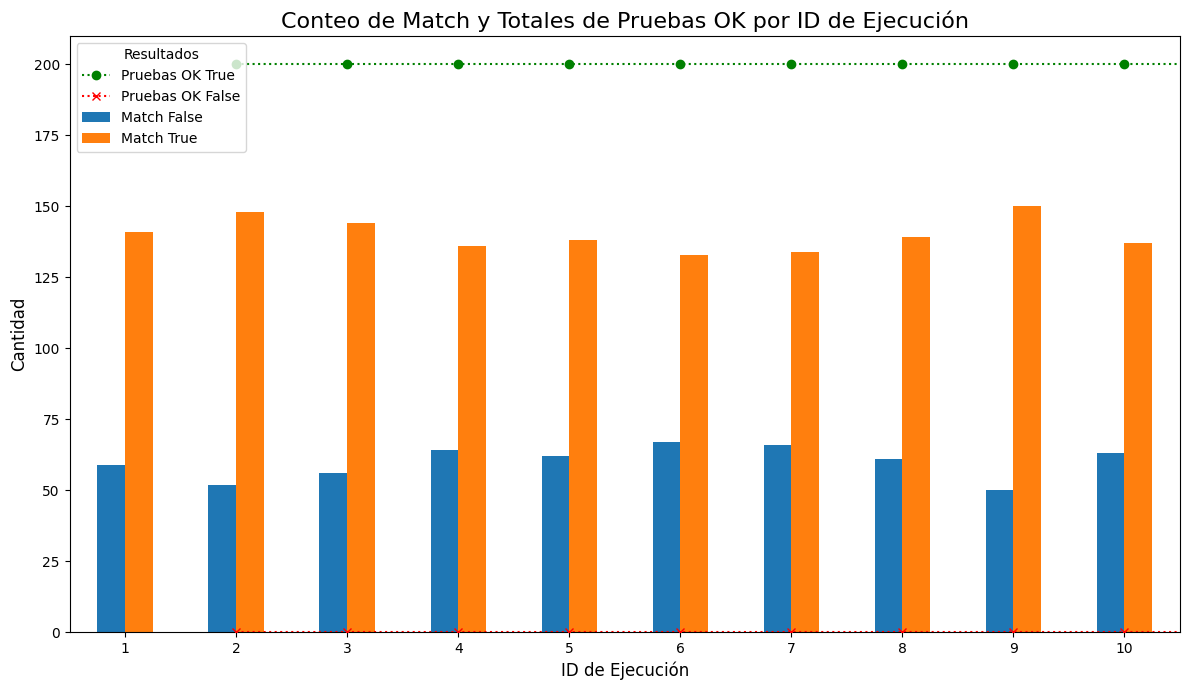

Gráfica generada exitosamente.


In [28]:
print("\nGenerando gráfica de resultados por ejecución...")
try:
    # Agrupar por ID de ejecución y valor de 'match', contar ocurrencias
    plot_data = log_df.groupby(['execution_id', 'match']).size()
    # Reorganizar para tener 'match' (True/False) como columnas
    # fill_value=0 asegura que si un ID solo tiene True o False, la otra columna aparezca con 0
    plot_data = plot_data.unstack(fill_value=0)

    # Renombrar columnas para la leyenda (opcional pero recomendado)
    plot_data = plot_data.rename(columns={True: 'Match True', False: 'Match False'})

    # 2. Preparar datos para las LÍNEAS (conteo de 'prueba_ok')
    pruebas_ok_counts = log_df.groupby(['execution_id', 'prueba_ok']).size()
    pruebas_ok_counts = pruebas_ok_counts.unstack(fill_value=0)
    # Asegurarse de que ambas columnas (True/False) existan, incluso si un ID solo tiene un tipo
    if True not in pruebas_ok_counts.columns:
        pruebas_ok_counts[True] = 0
    if False not in pruebas_ok_counts.columns:
        pruebas_ok_counts[False] = 0
    # Renombrar para la leyenda
    pruebas_ok_counts = pruebas_ok_counts.rename(columns={True: 'Pruebas OK True', False: 'Pruebas OK False'})


    # 3. Crear la gráfica de barras como base
    ax = plot_data.plot(kind='bar', figsize=(12, 7), rot=0, zorder=2) # zorder=2 para que las barras estén delante de la cuadrícula

    # 4. Añadir las LÍNEAS sobre las barras existentes (usando el mismo 'ax')
    pruebas_ok_counts['Pruebas OK True'].plot(ax=ax, kind='line', marker='o', linestyle=':', color='green', label=f'Pruebas OK True', zorder=3)
    pruebas_ok_counts['Pruebas OK False'].plot(ax=ax, kind='line', marker='x', linestyle=':', color='red', label=f'Pruebas OK False', zorder=3)


    # Configurar títulos y etiquetas (en español)
    ax.set_title('Conteo de Match y Totales de Pruebas OK por ID de Ejecución', fontsize=16)
    ax.set_xlabel('ID de Ejecución', fontsize=12)
    ax.set_ylabel('Cantidad', fontsize=12)
    ax.legend(title='Resultados') # La leyenda ahora incluirá las líneas
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)

    # Ajustar diseño y mostrar la gráfica
    plt.tight_layout() # Ajusta el espaciado para evitar solapamientos
    plt.show() # Muestra la gráfica generada
    print("Gráfica generada exitosamente.")

except Exception as e:
    print(f"\nError al generar la gráfica: {e}")


In [34]:
# --- Bloque: Crear DataFrame Consolidado ---
print("\nCreando DataFrame consolidado por execution_id...")
try:
    # Agrupar por execution_id y agregar los conteos necesarios
    summary_df = log_df.groupby('execution_id').agg(
        # Contar match True (suma los booleanos donde True=1)
        match_true_count=('match', lambda x: x.sum()),
        # Contar donde match es True Y prueba_ok es True
        match_true_pruebas_ok_true_count=('prueba_ok', lambda x: (log_df.loc[x.index, 'match'] & x).sum()),
        # Contar match False (suma los booleanos invertidos)
        match_false_count=('match', lambda x: (~x).sum()),
        # Contar donde match es False Y prueba_ok es True
        match_false_pruebas_ok_true_count=('prueba_ok', lambda x: (~log_df.loc[x.index, 'match'] & x).sum())
    )

    # Convertir los conteos a tipo entero
    summary_df = summary_df.astype(int)

    # Convertir el índice (execution_id) a una columna regular
    summary_df = summary_df.reset_index()

    summary_df['% aciertos verdadero'] = summary_df['match_true_pruebas_ok_true_count']*100/summary_df['match_true_count']
    summary_df['% aciertos falsos'] = summary_df['match_false_pruebas_ok_true_count']*100/summary_df['match_false_count']

    print("DataFrame consolidado creado exitosamente.")
except Exception as e:
    print(f"Error al crear el DataFrame consolidado: {e}")



Creando DataFrame consolidado por execution_id...
DataFrame consolidado creado exitosamente.


In [37]:
summary_df.describe()

,execution_id,match_true_count,match_true_pruebas_ok_true_count,match_false_count,match_false_pruebas_ok_true_count,% aciertos verdadero,% aciertos falsos
count,10.0,10.000000,10.000000,10.000000,10.000000,10.0,10.0
mean,5.5,140.000000,140.000000,60.000000,60.000000,100.0,100.0
std,3.02765,5.734884,5.734884,5.734884,5.734884,0.0,0.0
min,1.0,133.000000,133.000000,50.000000,50.000000,100.0,100.0
25%,3.25,136.250000,136.250000,56.750000,56.750000,100.0,100.0
50%,5.5,138.500000,138.500000,61.500000,61.500000,100.0,100.0
75%,7.75,143.250000,143.250000,63.750000,63.750000,100.0,100.0
max,10.0,150.000000,150.000000,67.000000,67.000000,100.0,100.0


In [38]:
output_csv_path = os.path.join(base_dir, 'consolidados.csv')
try:
    summary_df.to_csv(output_csv_path, index=False, encoding='utf-8')
    print(f"\nDataFrame guardado exitosamente en: {output_csv_path}")
except Exception as e:
    print(f"\nError al guardar el DataFrame en CSV: {e}")



DataFrame guardado exitosamente en: /home/jovyan/work/data/consolidados.csv
